# Autoregressive logistic regression

Replicate example on _Changes in evapotranspiration rates_ presented in: 

- B. Kedem and K. Fokianos, Regression models for time series analysis, 2002, p. 39
- A. Agresti, Categorical data analysis, 3rd ed., 2014, p. 474  

In [1]:
import pandas as pd

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

3.5


In [13]:
SEED = 20180727

In [85]:
obs = [int(i) for i in str(111111110001111100000001111000100000111111110011000000011111100000000011111110000000)]
obs = np.asarray(obs)
print(obs)
print(obs.shape)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 0]
(84,)


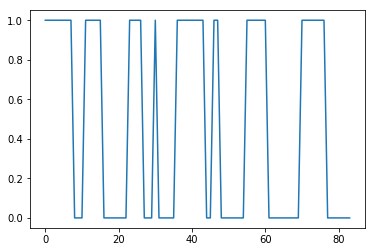

In [86]:
plt.plot(obs);

To build an autoregressive model, I use the observation at `t-1` as predictor for the observation at `t`

In [87]:
obs_t_minus_1 = obs[:-1].copy()
obs_t_minus_1

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

However, for the first observation I don't have the observation at the previous time step. Hence I will insert a missing observation (coded as `-1`)

In [88]:
obs_t_minus_1 = np.insert(obs_t_minus_1, 0, -1)
obs_t_minus_1.shape

(84,)

In [94]:
# There seems to be a problem when I have a single missing value. Here, I test with more than 1
obs_t_minus_1[:2] = -1

I will use the numpy `masked_array` to deal with the missing observation. In this way I can predict what the value for that observation was via the Bayesian inference

In [95]:
import numpy.ma as ma

In [96]:
obs_t_minus_1_ma = ma.masked_where(obs_t_minus_1==-1, obs_t_minus_1)
obs_t_minus_1_ma

masked_array(data=[--, --, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
                   0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                   1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
             mask=[ True,  True, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, Fal

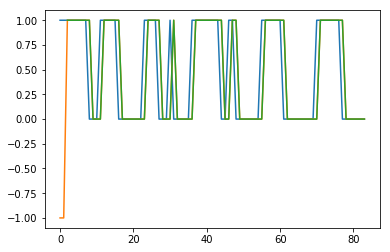

In [97]:
plt.plot(obs)
plt.plot(obs_t_minus_1)
plt.plot(obs_t_minus_1_ma) # the missing value is not plotted. That's good

In [98]:
with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    p_missing = pm.Beta('p_missing', alpha=2, beta=2)
    obs_t_minus_1_missing = pm.Bernoulli('obs_t_minus_1_missing', p=p_missing, observed=obs_t_minus_1_ma)
    
    p = pm.math.invlogit(alpha + pm.math.dot(beta, obs_t_minus_1_missing))
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=obs)
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=1, random_seed=SEED)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [p_missing, beta, alpha]
>BinaryGibbsMetropolis: [obs_t_minus_1_missing_missing]
100%|█████████████████████████████████████| 4000/4000 [00:07<00:00, 545.93it/s]


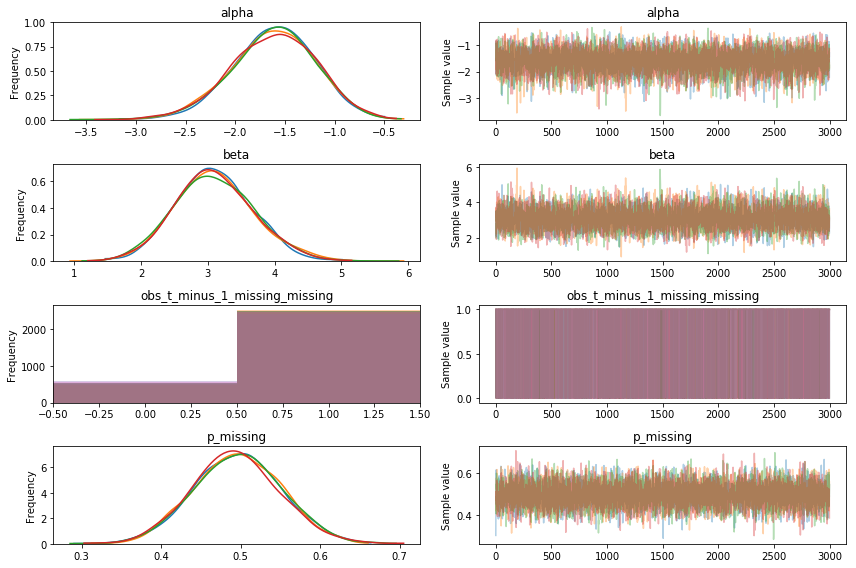

In [99]:
pm.traceplot(trace);

In [100]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.616172,0.423134,0.005017,-2.439622,-0.803063,6497.794178,0.999925
beta,3.103168,0.583269,0.006894,2.002782,4.294067,6751.868943,0.999910
obs_t_minus_1_missing_missing__0,0.819250,0.384811,0.003807,0.000000,1.000000,10727.447030,1.000137
obs_t_minus_1_missing_missing__1,0.829000,0.376509,0.003170,0.000000,1.000000,11167.130241,1.000141
p_missing,0.496021,0.054045,0.000642,0.392757,0.602027,7658.135174,1.000263
